# Bidirectional Encoder Representations from Transformers (BERT)

BERT stands for Bidirectional Encoder Representations from Transformers. Unlike recent language representation models, BERT is designed to pre-train deep bidirectional representations from unlabeled text by jointly conditioning on both left and right context in all layers. As a result, the pre-trained BERT model can be fine-tuned with just one additional output layer to create state-of-the-art models for a wide range of tasks, such as question answering and language inference, without substantial task-specific architecture modifications.

## Topic Modeling using BERT


### Load Data - ABC News Sample dataset - https://www.kaggle.com/datasets/bansodesandeep/abc-news-sample

In [5]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [6]:
import pandas as pd
# data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/abcnews_sample.csv')

In [7]:
# Load datasets
comments1 = pd.read_csv(r'/gdrive/My Drive/comments1.csv')

# comments3 = pd.read_csv(r'/gdrive/My Drive/comments3.csv')

comments4 = pd.read_csv(r'/gdrive/My Drive/comments4.csv')

comments6 = pd.read_csv(r'/gdrive/My Drive/comments6.csv')

In [8]:
# concatenate the dataframes
df_concat = pd.concat([comments1, comments4, comments6])

In [9]:
df_concat.columns

Index(['Comment ID', 'Author', 'Timestamp', 'Comment is a reply to',
       'Comment Thread ID', 'Thread Title', 'Comment Body',
       'Comment Permalink', 'MsgID', 'ThreadID', 'ThreadTitle', 'ReplyTo',
       'Permalink'],
      dtype='object')

In [10]:
df = (df_concat.drop_duplicates()
             .dropna(subset=["Comment Body"])
             .reset_index(drop=True))

In [11]:
data = df.rename(columns={'Comment Body': 'headline_text'})

In [12]:
data.columns

Index(['Comment ID', 'Author', 'Timestamp', 'Comment is a reply to',
       'Comment Thread ID', 'Thread Title', 'headline_text',
       'Comment Permalink', 'MsgID', 'ThreadID', 'ThreadTitle', 'ReplyTo',
       'Permalink'],
      dtype='object')

In [13]:
# Create a new column containing the length each headline text
data["headline_text_len"] = data["headline_text"].apply(lambda x : len(x.split()))

In [14]:
data_text = data[['headline_text']];

In [15]:
print("The longest headline has: {} words".format(data.headline_text_len.max()))

The longest headline has: 1320 words


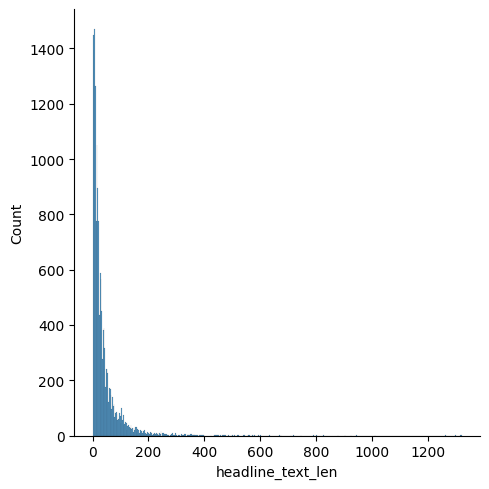

In [16]:
# Visualize the length distribution 
import seaborn as sns
import matplotlib.pyplot as plt
sns.displot(data.headline_text_len, kde=False)

### Topic Modeling
In this example, we will go through the main components of BERTopic and the steps necessary to create a strong topic model.

#### Training
We start by instantiating BERTopic. We set language to english since our documents are in the English language. If you would like to use a multi-lingual model, please use language="multilingual" instead.

We will also calculate the topic probabilities. However, this can slow down BERTopic significantly at large amounts of data (>100_000 documents). It is advised to turn this off if you want to speed up the model.

In [17]:
!pip install bertopic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.7/120.7 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 10.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 10.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 51.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 107.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 72.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 72.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  

BERTopic is a topic modeling technique that leverages BERT embeddings and c-TF-IDF to create dense clusters allowing for easily interpretable topics whilst keeping important words in the topic descriptions.

The default embedding model is all-MiniLM-L6-v2 when selecting language="english" and paraphrase-multilingual-MiniLM-L12-v2 when selecting language="multilingual".

Documentation: https://maartengr.github.io/BERTopic/api/bertopic.html

In [18]:
%%time
from bertopic import BERTopic
model = BERTopic(verbose=True,embedding_model='paraphrase-MiniLM-L3-v2', min_topic_size= 10)
headline_topics, _ = model.fit_transform(data.headline_text)

Batches:   0%|          | 0/513 [00:00<?, ?it/s]

2023-04-22 19:32:56,084 - BERTopic - Transformed documents to Embeddings
2023-04-22 19:33:37,669 - BERTopic - Reduced dimensionality
2023-04-22 19:33:40,571 - BERTopic - Clustered reduced embeddings


CPU times: user 1min 26s, sys: 3.95 s, total: 1min 30s
Wall time: 1min 49s


In [19]:
from umap import UMAP

In [20]:
# Initiate UMAP
umap_model = UMAP(n_neighbors=15, 
                  n_components=5, 
                  min_dist=0.0, 
                  metric='cosine', 
                  random_state=100)
# Initiate BERTopic
model = BERTopic(umap_model=umap_model, language="english", calculate_probabilities=True)
# Run BERTopic model
headline_topics, probabilities = model.fit_transform(data.headline_text)

2023-04-22 19:34:07,297 - BERTopic - Transformed documents to Embeddings
2023-04-22 19:34:32,579 - BERTopic - Reduced dimensionality
2023-04-22 19:35:04,117 - BERTopic - Clustered reduced embeddings


BERTopic model by default produces different results each time because of the stochasticity inherited from UMAP.

To get reproducible topics, we need to pass a value to the random_state parameter in the UMAP method.

n_neighbors=15 means that the local neighborhood size for UMAP is 15. This is the parameter that controls the local versus global structure in data.

A low value forces UMAP to focus more on local structure, and may lose insights into the big picture.

A high value pushes UMAP to look at the broader neighborhood, and may lose details on local structure.

The default n_neighbors values for UMAP is 15.

n_components=5 indicates that the target dimension from UMAP is 5. This is the dimension of data that will be passed into the clustering model.

min_dist controls how tightly UMAP is allowed to pack points together. It's the minimum distance between points in the low dimensional space.

Small values of min_dist result in clumpier embeddings, which is good for clustering. Since our goal of dimension reduction is to build clustering models, we set min_dist to 0.

Large values of min_dist prevent UMAP from packing points together and preserves the broad structure of data.

metric='cosine' indicates that we will use cosine to measure the distance.
random_state sets a random seed to make the UMAP results reproducible.

After initiating the UMAP model, we pass it to the BERTopic model, set the language to English, and set the calculate_probabilities parameter to True.

Finally, we pass the processed review documents to the topic model and saved the results for topics and topic probabilities.

The values in topics represents the topic each document is assigned to.
The values in probabilities represents the probability of a document belongs to each of the topics.

#### Topic Extraction and Representation

In [21]:
freq = model.get_topic_info()
print("Number of topics: {}".format( len(freq)))
freq.head()

Number of topics: 229


,Topic,Count,Name
0,-1,7563,-1_to_and_the_you
1,0,299,0_age_18_old_younger
2,1,294,1_feminism_feminist_feminists_equality
3,2,247,2_baby_child_pregnant_birth
4,3,236,3_song_songs_wrote_written


The above table has 3 main columns, providing information about all the topics in descending order of topics size/Count.

'Topic' is the topic number, a kind of identifier, and the outliers are labeled as -1. Those are topics that should be ignored because they do not bring any added value.
'Count' is the number of words in the topic.
Name is the name given to the topic.
For each topic, we can retrieve the top words and their corresponding c-TF-IDF score. The higher the score, the most relevant the word is in representing the topic.

In [22]:
a_topic = freq.iloc[1]["Topic"] # Select the 1st topic
model.get_topic(a_topic) # Show the words and their c-TF-IDF scores

[('age', 0.023087979304623425),
 ('18', 0.020473705071110633),
 ('old', 0.016520220135939852),
 ('younger', 0.01583926329159641),
 ('25', 0.014755681049120775),
 ('older', 0.014520379763963252),
 ('young', 0.013037260034681423),
 ('year', 0.012869147011797128),
 ('adult', 0.011488284858472687),
 ('years', 0.008398725339804857)]

From this topic, we observe that all the words are coherent for the underlying topic which seems to be about firefighters 🔥.

####Topics Visualization.
The topic visualization helps in gaining more insight about each topic. BERTopic provides several visualization possibilities such as terms visualization, intertopic distance map, topic hierarchy clustering just to name a few, and our focus will be on those that have been cited.

#### Topic Terms
The most relevant words of each topic can be visualized in a form of barchart out of the c-TF-IDF score, which is interesting to visually compare topics. Below is the corresponding visualization for the topic 10 topics.

In [23]:
model.visualize_barchart(top_n_topics=10)

#### Intertopic Distance Map
For those who are fimiliar with Latent Dirichlet Allocation LDAvis library. 

This library provides the user with an interactive dashboard showing for each topic the corresponding words and their score. 

BERTopic does the same with its visualize_topics() function and even go one step further by giving the distance between topics (the lower the most similar), and all of this with a single function visualize_topics()

In [24]:
model.visualize_topics(top_n_topics=20)

#### Visualize Topic Hierarchy¶
As you can see in the Interdistance topic dashboard, some topics are very close. 

One thing that could come to mind is how can I reduce the number of topics? 

The good news is that those topics can be hierarchically in order to select the appropriate number of topics. The visualization flavor helps to understand how they relate to one another.

In [25]:
model.visualize_hierarchy(top_n_topics=30)

By looking at the first level (level 0) of the dendogram, we can see that topics with the same colors have been grouped together. 

All these information can help the user better understand the reason why the topics have been considered to be similar one to another.

#### Search Topics
Once the topic model is trained, we can search for topics that are semantically similar to an input query word/term using the find_topics function. In our case, we can search for top 3 topics that are related to the word 'politics'

In [26]:
# Select most 3 similar topics
similar_topics, similarity = model.find_topics("cyberbullying", top_n = 3)

similar_topics contains the topics index from most similar to least similar.
similarity contains the similarity scores in descending order.

In [27]:
similar_topics 

[206, 69, 138]

In [28]:
most_similar = similar_topics[0]
print("The Most Similar Topic Info: \n{}".format(model.get_topic(most_similar)))
print("Similarity Score: {}".format(similarity[0]))

The Most Similar Topic Info: 
[('harassed', 0.051295895919959235), ('sexual', 0.04811644417674394), ('harassment', 0.04313261263960554), ('sexually', 0.039985133670750114), ('unattractive', 0.027756012411564335), ('rapist', 0.025870765616185093), ('cops', 0.025228111620757474), ('money', 0.02446762668192889), ('opinion', 0.024421950050148834), ('isnt', 0.024240108466978178)]
Similarity Score: 0.5493095173513025


#### Conclusion
Now, you know how to use BERTopic for topic modeling. The results are very encouraging, and do not hesitate to give it a try on your business case. However, it is important to note that the results of BERTopic are not consistent between runs, this is due to the stochastic nature of UMAP used for dimensionality reduction. 

So, using the random_state parameter in UMAP the any stochastic behavior.

Reference kaggle post - https://www.kaggle.com/code/bansodesandeep/topic-modeling-with-bert/notebook

## BERT for Sentiment Analysis 

We will do the following operations to train a sentiment analysis model:

- Install Transformers library;
- Load the BERT Classifier and Tokenizer alıng with Input modules;
- Download the IMDB Reviews Data and create a processed dataset (this will take several operations;
- Configure the Loaded BERT model and Train for Fine-tuning
- Make Predictions with the Fine-tuned Model


### Intalling the Transformers library from Huggingface 
Huggingface's Transformers Library provides thousands of pretrained models to perform tasks on texts such as classification, information extraction, question answering, summarization, translation, text generation, etc in 100+ languages. Its aim is to make cutting-edge NLP easier to use for everyone.

In [29]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


used saved trained bert model

In [34]:
from google.colab import drive
drive.mount('/gdrive')

from transformers import TFBertForSequenceClassification, BertTokenizer

# Load the model from Google Drive
model = TFBertForSequenceClassification.from_pretrained("/gdrive/My Drive/saved_model")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")


Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


Some layers from the model checkpoint at /gdrive/My Drive/saved_model were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /gdrive/My Drive/saved_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


predicting bullying

In [51]:
import tensorflow as tf
predictions = []
labels = ['Not Cyberbullying','Cyberbullying']

In [29]:


# Iterate through the 'headline_text' column of your dataset
for text in data['headline_text']:
    # Tokenize the text using the pre-trained BERT tokenizer
    tf_batch = tokenizer([text], max_length=128, padding=True, truncation=True, return_tensors='tf')
    tf_outputs = model(tf_batch)
    tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)
    label = tf.argmax(tf_predictions, axis=1)
    label = label.numpy()
    # Append the predicted label to the list of predictions
    predictions.append(labels[label[0]])  
    print('text:', text, 'label:', labels[label[0]])

Streaming output truncated to the last 5000 lines.
Whats that got to do with women?
Absolutely nothing, and thats the point! I'm doing it for me!

Gonna plant Yucca (Casava) hard corn, Grandul a tropical tasting little bean, got a couple Papachilicanas they are a beautiful vine. Might look for sweet potatoes... and hot peppers...

And I aint feedin' no pig.

Just me and four German Shepherds... label: Not Cyberbullying
text: Bruh, what is this obsession with 183 cm? 🤣





I've never heard anyone in my own personal life state that as a requirement to dating. I should be thankful that I'm surrounded by positive and non toxic women. label: Not Cyberbullying
text: 
I like it balanced both upstairs and downstairs, but that's me.  Oh, a nice butt will do it!  Of course, if he has a voice that makes my toes curl, oh yeah, baby.  Just as long as it's on both sides.  

Yeah, that means I am going to have to work out more to get that, eh?  Taller than me brownish green or green or amber eyed an

add prediction column

In [30]:
# Add a new column to the DataFrame with the predictions
data['predicted_cyberbullying_type'] = predictions

save output

In [31]:
# Save the DataFrame as a CSV file in the local environment
data.to_csv("output.csv", index=False)

# Copy the CSV file to Google Drive
!cp output.csv "/gdrive/My Drive/DM2finaloutput.csv"


Function to work on predicting bullying

In [52]:
import re
import tensorflow as tf

def predict_and_suggest(text, model, tokenizer, labels):
    # Tokenize the input text
    tf_batch = tokenizer([text], max_length=128, padding=True, truncation=True, return_tensors='tf')

    # Predict the cyberbullying type
    tf_outputs = model(tf_batch)
    tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)
    label_indices = tf.argmax(tf_predictions, axis=1)
    label_indices = label_indices.numpy()

    # Check if the text is identified as cyberbullying
    if labels[label_indices[0]] == "Negative":
        print("The text is identified as cyberbullying. Please modify the text.")
        
        # Identify cyberbullying words
        # Replace this list with the actual words that you want to consider as cyberbullying
        cyberbullying_words = ["badword1", "badword2", "badword3"]
        
        # Replace cyberbullying words with alternatives or mask them
        modified_text = text
        for word in cyberbullying_words:
            if word in modified_text:
                # Replace the word with an alternative (e.g., "****")
                modified_text = re.sub(word, "****", modified_text)
        
        print("Suggested modification:", modified_text)
    else:
        print("The text is not identified as cyberbullying.")

Testing Output

In [55]:
input_text = "badword1"
predict_and_suggest(input_text, model, tokenizer, labels)

The text is not identified as cyberbullying.


In [30]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [31]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


### Load the IMDB Movie Review Data and Preprocess 

In [32]:
df = pd.read_csv(r'/gdrive/My Drive/cyberbullying.csv')
print('No. of rows and columns :', df.shape)
df.head(10)

No. of rows and columns : (28181, 2)


,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",Not Cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,Not Cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,Not Cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",Not Cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,Not Cyberbullying
5,"@Raja5aab @Quickieleaks Yes, the test of god i...",Not Cyberbullying
6,Itu sekolah ya bukan tempat bully! Ga jauh kay...,Not Cyberbullying
7,Karma. I hope it bites Kat on the butt. She is...,Not Cyberbullying
8,@stockputout everything but mostly my priest,Not Cyberbullying
9,Rebecca Black Drops Out of School Due to Bully...,Not Cyberbullying


In [33]:
!python -m spacy download en_core_web_lg

2023-04-22 19:41:24.095405: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [34]:
import spacy
import re
#loads the pre-trained spaCy model for English language processing, 
nlp = spacy.load("en_core_web_lg")

# function to return a string that represents the lemmatized version of the input 
def normalize(review, lowercase, remove_stopwords):
    if lowercase:
        review = review.lower()
    doc = nlp(review)
    lemmatized = list()
    for token in doc:
        if not remove_stopwords or (remove_stopwords and not token.is_stop):
            lemmatized.append(token.lemma_)
    return " ".join(lemmatized)

In [35]:
def alpha_num(text):
    return re.sub(r'[^A-Za-z0-9 ]', '', text)

# to remove URLs
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

# to remove html tags
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

In [36]:
df['tweet_text'] = df['tweet_text'].apply(remove_URL)
df['tweet_text'] = df['tweet_text'].apply(remove_html)
#df['review'] = df['review'].apply(alpha_num)
#df['review'] = df['review'].apply(normalize, lowercase=True, remove_stopwords=True)

df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",Not Cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,Not Cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,Not Cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",Not Cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,Not Cyberbullying


In [37]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(df['cyberbullying_type'])
df['labels'] = label_encoder.transform(df['cyberbullying_type'])

In [38]:
from sklearn.model_selection import train_test_split
# train-test split
train_sentences, test_sentences, train_labels, test_labels = train_test_split(df['tweet_text'], df['labels'], test_size=0.2, random_state=5, stratify=df['labels'])


In [39]:
train =pd.DataFrame([train_sentences, train_labels]).T
train.head()

,tweet_text,labels
17433,of course it always fucking comes to this shit...,0
26823,all your posts are subtly anti trump and upvot...,0
25682,indian is a racist term you shitlord https np ...,0
22593,yes lol hahahahaha fucking retarded,0
14948,you re a massive faggot,0


In [40]:
test = pd.DataFrame([test_sentences, test_labels]).T
test.head()

,tweet_text,labels
10528,this post right here is the exact reason peopl...,0
5176,#gymflow as my sister just showed off her push...,1
11024,lol you sound like a huge faggot,0
872,@Feminazi_Front @She_TheWolf @brotheryellow Bi...,1
21972,dont be shit quit bitching you fucking baby,0


### Create the Input Sequences 

We have two pandas Dataframe objects waiting for us to convert them into suitable objects for the BERT model. We will take advantage of the InputExample function that helps us to create sequences from our dataset.

https://huggingface.co/docs/transformers/v4.28.1/en/main_classes/processors#transformers.InputExample

Now we will create two main functions:

— convert_data_to_examples: This will accept our train and test datasets and convert each row into an InputExample object.

— convert_examples_to_tf_dataset: This function will tokenize the InputExample objects, then create the required input format with the tokenized objects, finally, create an input dataset that we can feed to the model.

In [41]:
import tensorflow as tf
def convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN): 
  train_InputExamples = train.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)

  validation_InputExamples = test.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)
  
  return train_InputExamples, validation_InputExamples

  train_InputExamples, validation_InputExamples = convert_data_to_examples(train, 
                                                                           test, 
                                                                           'DATA_COLUMN', 
                                                                           'LABEL_COLUMN')
  
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = [] # -> will hold InputFeatures to be converted later

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
            truncation=True
        )

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
            input_dict["token_type_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label
            )
        )

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )


DATA_COLUMN = 'tweet_text'
LABEL_COLUMN = 'labels'

In [42]:
train_InputExamples, validation_InputExamples = convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN)

train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
train_data = train_data.shuffle(100).batch(32).repeat(2)

validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer)
validation_data = validation_data.batch(32)

### Configuring the BERT model and Fine-tuning
We will use Adam as our optimizer, CategoricalCrossentropy as our loss function, and SparseCategoricalAccuracy as our accuracy metric. Fine-tuning the model for 2 epochs will give us around 95% accuracy.



In [43]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

model.fit(train_data, epochs=2, validation_data=validation_data)

Epoch 1/2
1410/1410 [==============================] - 1260s 851ms/step - loss: 0.0155 - accuracy: 0.9949 - val_loss: 0.0021 - val_accuracy: 0.9993
Epoch 2/2
1410/1410 [==============================] - 1174s 832ms/step - loss: 0.0019 - accuracy: 0.9996 - val_loss: 0.0060 - val_accuracy: 0.9993


In [44]:
# Save the model to a local directory
model.save_pretrained("saved_model")

# Copy the saved model to Google Drive
!cp -r saved_model "/gdrive/My Drive/saved_model"

### Making Predictions
I created a list of two reviews I created. The first one is a positive review, while the second one is clearly negative.

In [ ]:
predictions = []

We need to tokenize our reviews with our pre-trained BERT tokenizer. We will then feed these tokenized sequences to our model and run a final softmax layer to get the predictions. We can then use the argmax function to determine whether our sentiment prediction for the review is positive or negative. Finally, we will print out the results with a simple for loop. The following lines do all of these said operations:

In [ ]:
# Iterate through the 'headline_text' column of your dataset
for text in data['headline_text']:
    # Tokenize the text using the pre-trained BERT tokenizer
    tf_batch = tokenizer([text], max_length=128, padding=True, truncation=True, return_tensors='tf')
    tf_outputs = model(tf_batch)
    tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)
    labels = ['Not Cyberbullying','Cyberbullying']
    label = tf.argmax(tf_predictions, axis=1)
    label = label.numpy()
    # Append the predicted label to the list of predictions
    predictions.append(labels[label[0]])  
    print('text:', text, 'label:', labels[label[0]])

Streaming output truncated to the last 5000 lines.
Another guy told of how he grew up hearing his dad wasn’t not interested in being a father until he confronted him in his early 20s and was shown multiple court filings requesting visitation. label: Not Cyberbullying
text: 😂😂😂🤦🏼‍♀️🤦🏼‍♀️ biggest bs i ever read.

and how is it the girls fault if birth control fails if she still took it regularly. no birth control is 100% safe if you know the pearl index. Birth control is BOTH partners business and if it doesnt work, both people are responsible, not just the person who's body the baby is in.

And to say the main reason for single mothers is mothers cheating with their birthcontrol and being viscious and planning s pregnancy behind their partners back is just so far off from reality and deluded i dont know what to say 😂😶 label: Not Cyberbullying
text: Abortion is what’s selfish label: Not Cyberbullying
text: There’s a time I asked in a forum how does a woman hookup with a guy with two baby

In [ ]:
# Add a new column to the DataFrame with the predictions
data['predicted_cyberbullying_type'] = predictions

In [ ]:
# Save the DataFrame as a CSV file in the local environment
data.to_csv("output.csv", index=False)

# Copy the CSV file to Google Drive
!cp output.csv "/gdrive/My Drive/DM2finaloutput.csv"


In [ ]:
import re

def predict_and_suggest(text, model, tokenizer, labels):
    # Tokenize the input text
    tf_batch = tokenizer([text], max_length=128, padding=True, truncation=True, return_tensors='tf')

    # Predict the cyberbullying type
    tf_outputs = model(tf_batch)
    tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)
    label_indices = tf.argmax(tf_predictions, axis=1)
    label_indices = label_indices.numpy()

    # Check if the text is identified as cyberbullying
    if labels[label_indices[0]] == "Negative":
        print("The text is identified as cyberbullying. Please modify the text.")
        
        # Identify cyberbullying words
        # Replace this list with the actual words that you want to consider as cyberbullying
        cyberbullying_words = ["badword1", "badword2", "badword3"]
        
        # Replace cyberbullying words with alternatives or mask them
        modified_text = text
        for word in cyberbullying_words:
            if word in modified_text:
                # Replace the word with an alternative (e.g., "****")
                modified_text = re.sub(word, "****", modified_text)
        
        print("Suggested modification:", modified_text)
    else:
        print("The text is not identified as cyberbullying.")


In [ ]:
input_text = "This is a sample text containing badword1 and badword2."
predict_and_suggest(input_text, model, tokenizer, labels)